<a href="https://colab.research.google.com/github/gumdanx/fluffy-disco/blob/main/Whatsapp_%3E_Excel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

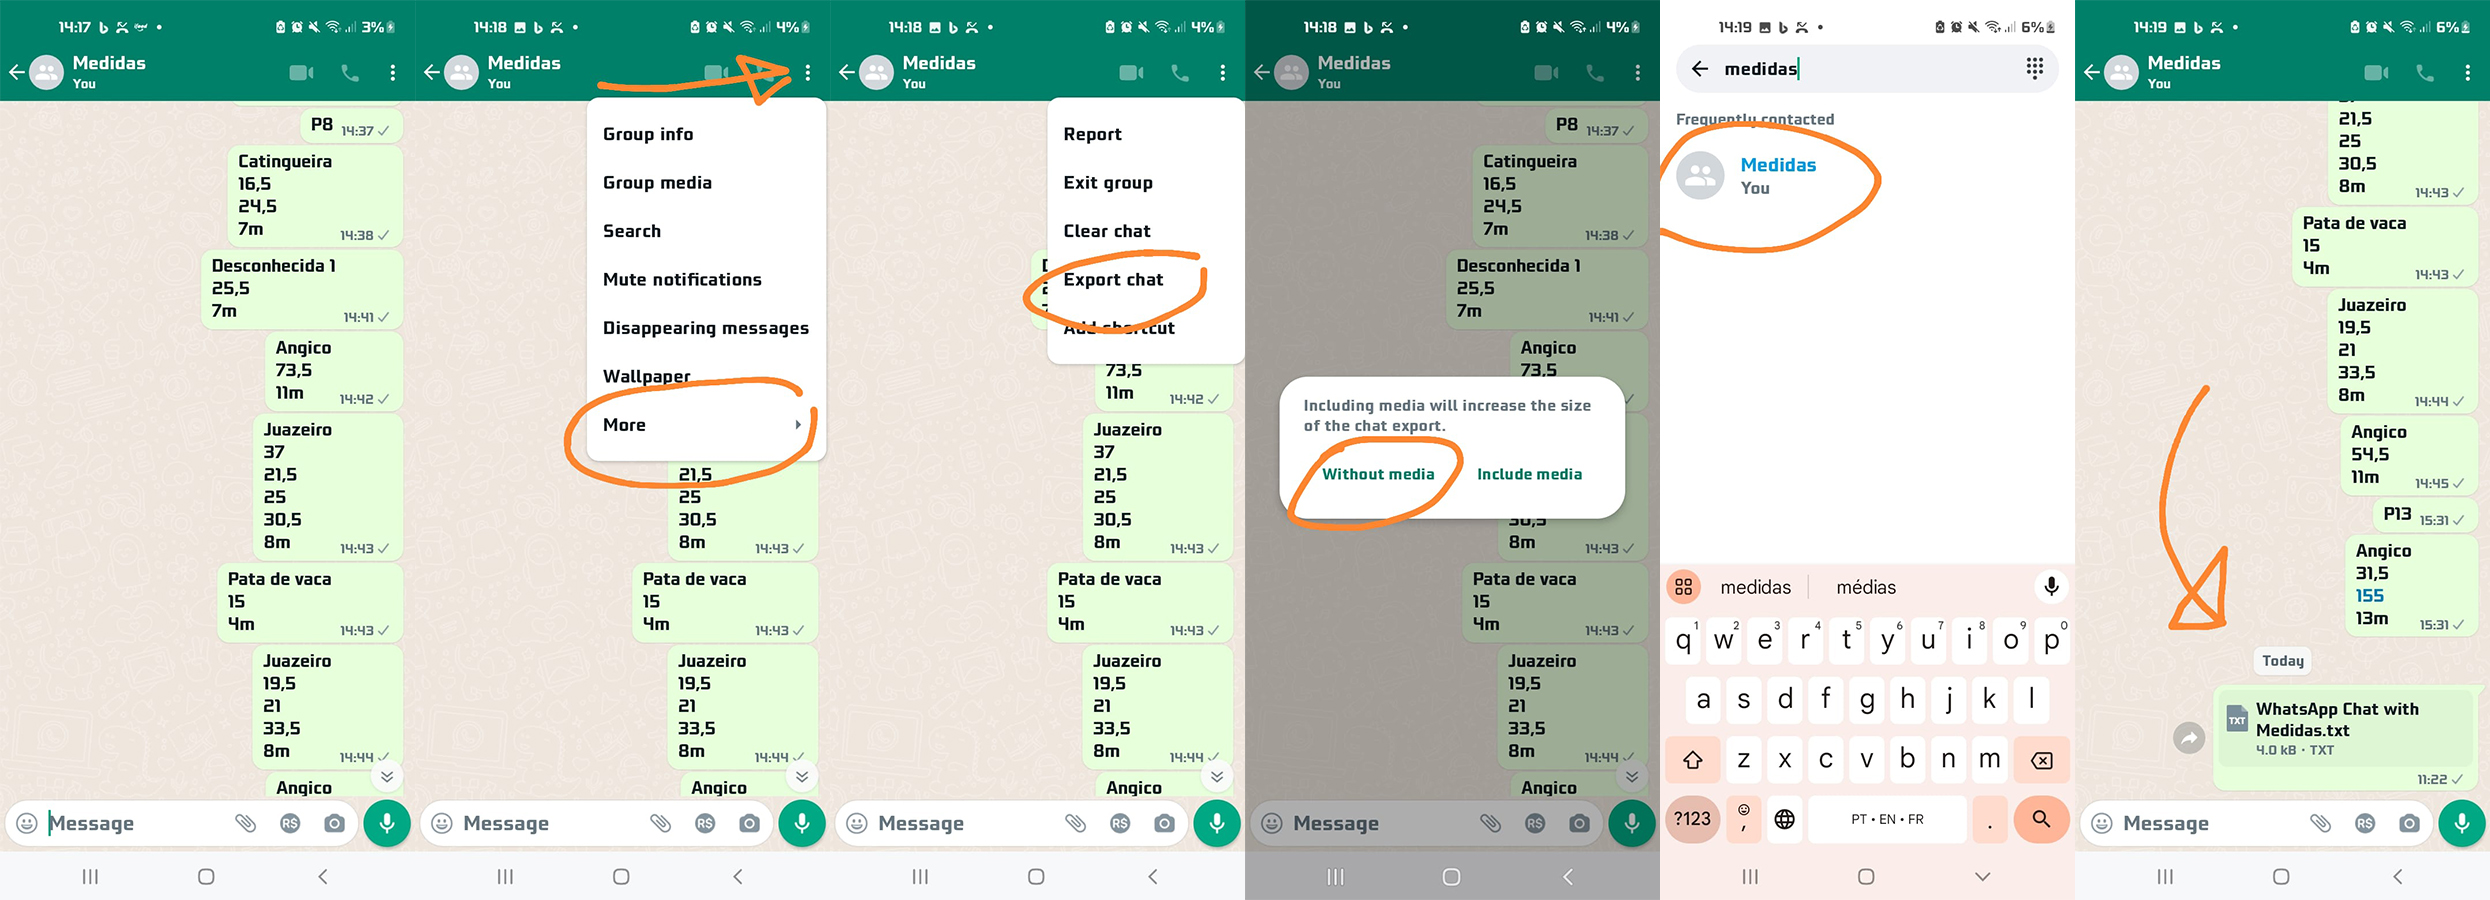

1.   Crie um grupo: Eu criei um chamado medidas
   *   Cada segmento marquei com o nome P1, P2, etc
   *   Nome da espécie, medidas e altura
2.   Botão opções no chat (três pontinhos)
   *   Clicar em "mais"
3.   Exportar chat
4.   Caso perguntar, sem adcionar mídia
5.   Compartilhe com esse próprio chat o arquivo gerado
6.   Baixe e faça o upload para sua cópia dessa página (ver instruções abaixo)



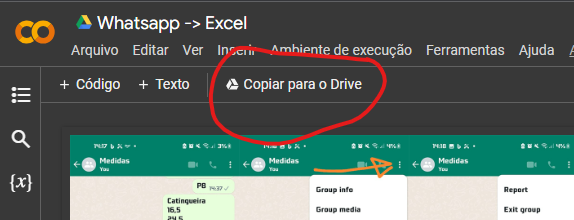

*   Copie essa página para seu drive, isso permite edição
*   Na pastinha aqui a esquerda você pode apagar meu arquivo `WhatsApp Chat with Medidas.txt` de exemplo
*   Clique com o botão direito e faça o upload da sua conversa exportada
*   No código abaixo você só precisa mudar o nome do arquivo dessa primeira linha de código para **exatamente** o nome do seu

Após isso, aperte os dois botões: Ctrl + F9

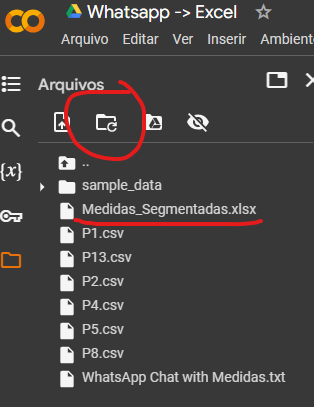

Atualize e faça o download do arquivo `medidas_segmentadas.xlsx`



In [ ]:
# Conversa exportada do Whatsapp
file_path = 'WhatsApp Chat with Medidas.txt'

with open(file_path, 'r') as file:
    content = file.readlines()

# Exibição das primeiras 10 linhas para checagem
content[:10]


['09/12/23, 10:40 - Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.\n',
 '09/12/23, 10:40 - You created group "Medidas"\n',
 '09/12/23, 10:42 - gdx: P1\n',
 '09/12/23, 10:42 - gdx: Pata de vaca\n',
 '18\n',
 '6m\n',
 '09/12/23, 10:42 - gdx: Pata de vaca\n',
 '24,5\n',
 '6m\n',
 '09/12/23, 10:43 - gdx: Pata de vaca\n']

In [ ]:
import re
import pandas as pd
from collections import defaultdict

# Função para processar o conteúdo do arquivo
def process_content(content):
    # Dicionário para armazenar os dados de cada segmento
    data_dict = defaultdict(list)

    # Variáveis para controle do processamento
    current_segment = None
    current_species = None
    current_height = None
    measures = []

    # Expressão regular para identificar mudanças de segmento e medições
    segment_pattern = re.compile(r"\d{2}/\d{2}/\d{2}, \d{2}:\d{2} - .+: P\d+")
    species_pattern = re.compile(r"^\d{2}/\d{2}/\d{2}, \d{2}:\d{2} - .+: (.+)$")
    measure_pattern = re.compile(r"^(\d+(?:,\d+)?)\n$")
    height_pattern = re.compile(r"^(\d+m)\n$")
    irrelevant_message_pattern = re.compile(r"^\d{2}/\d{2}/\d{2}, \d{2}:\d{2} - .+: (.*(?:apagou|deleted).*)\n$")

    # Processamento do conteúdo linha a linha
    for line in content:
        if irrelevant_message_pattern.match(line):
            # Ignorar mensagens irrelevantes
            continue
        elif segment_pattern.match(line):
            # Novo segmento identificado
            if current_segment and current_species:
                # Adicionar a medição anterior antes de mudar de segmento
                data_dict[current_segment].append([current_species, current_height, len(measures)] + measures)
            current_segment = line.strip().split()[-1]
            current_species = None
            current_height = None
            measures = []
        elif species_pattern.match(line):
            # Nova espécie identificada
            if current_species:
                # Adicionar a medição anterior antes de mudar de espécie
                data_dict[current_segment].append([current_species, current_height, len(measures)] + measures)
            current_species = species_pattern.match(line).group(1)
            measures = []
        elif height_pattern.match(line):
            # Nova altura identificada
            current_height = height_pattern.match(line).group(1)
        elif measure_pattern.match(line):
            # Nova medida identificada
            measures.append(measure_pattern.match(line).group(1))

    # Adicionar a última medição
    if current_species:
        data_dict[current_segment].append([current_species, current_height, len(measures)] + measures)

    return data_dict

# Processando o conteúdo do arquivo
data_dict = process_content(content)

# Determinando o número máximo de medidas em cada segmento
max_measures = {segment: max(len(row) - 3 for row in rows) for segment, rows in data_dict.items()}

# Criando DataFrames para cada segmento
dfs = {}
for segment, rows in data_dict.items():
    # Colunas para o DataFrame
    columns = ['Especie', 'Altura', 'Numero de medidas'] + [f'Medida {i+1}' for i in range(max_measures[segment])]

    # Preenchendo os dados ausentes com vazio
    for row in rows:
        while len(row) < len(columns):
            row.append('')

    # Criando o DataFrame
    dfs[segment] = pd.DataFrame(rows, columns=columns)

# Exibindo o DataFrame do primeiro segmento detectado
first_segment = list(dfs.keys())[0]  # Obtendo o nome do primeiro segmento
dfs[first_segment].head()  # Exibindo o DataFrame desse segmento

,Especie,Altura,Numero de medidas,Medida 1,Medida 2,Medida 3,Medida 4
0,Pata de vaca,6m,1,18,,,
1,Pata de vaca,6m,1,"24,5",,,
2,Pata de vaca,6m,1,24,,,
3,Pata de vaca,6m,4,"16,5",24,27,"20,5"
4,Pata de vaca,5m,1,21,,,


In [ ]:
# Salvando cada DataFrame como um arquivo CSV
csv_files = []
for segment, df in dfs.items():
    csv_file_path = f'{segment}.csv'
    df.to_csv(csv_file_path, index=False)
    csv_files.append(csv_file_path)

csv_files  # Listando os caminhos dos arquivos CSV gerados

['P1.csv', 'P2.csv', 'P5.csv', 'P4.csv', 'P8.csv', 'P13.csv']

In [ ]:
from pandas import ExcelWriter

# Caminho para o novo arquivo XLSX
xlsx_file_path = 'Medidas_Segmentadas.xlsx'

# Criando o arquivo XLSX com cada DataFrame como uma aba
with ExcelWriter(xlsx_file_path) as writer:
    for segment, df in dfs.items():
        df.to_excel(writer, sheet_name=segment, index=False)

xlsx_file_path  # Caminho do arquivo XLSX criado

'Medidas_Segmentadas.xlsx'